In [1]:
# This NB is same as nb13 but will produce plots based on 

ref='nb131-' 

import pandas as pd
import numpy as np

#%matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import matplotlib
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams.update({
    'font.family': 'serif',
    'axes.titlesize':16,
    'axes.labelsize':16,
    'axes.xmargin':0.1,
    'axes.ymargin':0.1,
    'legend.fontsize':16,
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 16,
    'lines.markersize': 10,
    'lines.linewidth' : 2,
    'font.size': 16
})


import datetime
import copy
import os


In [2]:
data=pd.read_csv("../data/processed/nb121-annot_gathered.csv")
subj_lst=data.drop_duplicates(['SubjectId','RunId'])['SubjectId'].values
run_lst=data.drop_duplicates(['SubjectId','RunId'])['RunId'].values
subj_run=tuple(zip(subj_lst,run_lst))
skip=0 #0,1,2,3..etc # skipped samples (i.e. downsampling)
subj_run=([(988.0,1.0)]) # Uncomment if you need to produce a single plot or specific plot. Provide them in tuples.

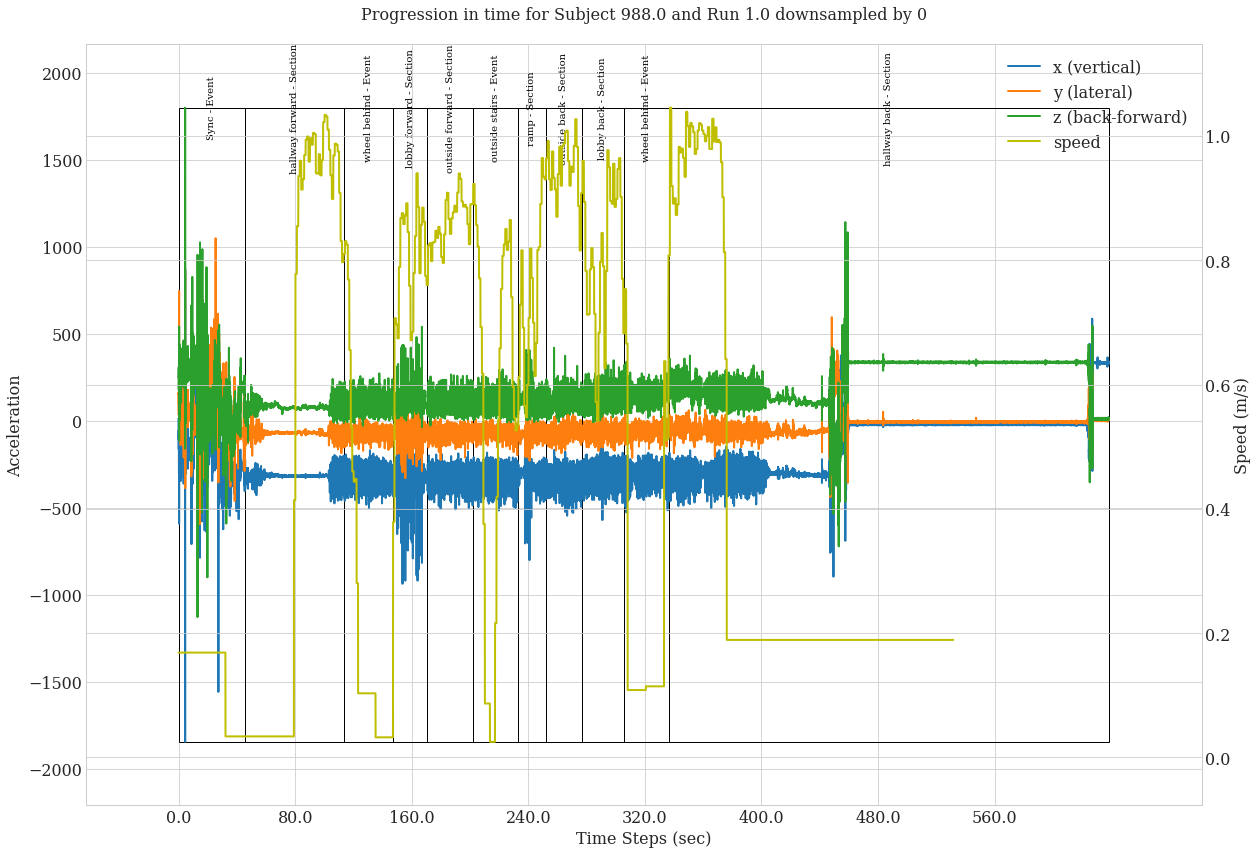

In [3]:
for selected_subject, selected_run in subj_run:
    
    # Fetch walk
    walk_data=data[data['SubjectId']==selected_subject]
    walk_data=walk_data[walk_data['RunId']==selected_run]
    walk_data.reset_index(drop=True,inplace=True)
    if skip != 0:
        walk_data=walk_data.iloc[::skip]
        walk_data.reset_index(drop=True,inplace=True)
    #subdata=np.array_split(data.values,n_subplots)

    #Get min and max accls in walk
    min_accl=np.min(walk_data.values[:,3:6])
    max_accl=np.max(walk_data.values[:,3:6])
    #Fetch segments per walk
    segments=walk_data['Annotation']!=walk_data['Annotation'].shift()
    segments=walk_data[segments]
    seg_idx=segments.index
    segment_data=[walk_data.iloc[seg_idx[i]:seg_idx[i+1]] for i in range(len(seg_idx)-1)]
    segment_data.append(walk_data.iloc[seg_idx[-1]:]) 
    annot=segments['Annotation'].values
    annot_type=segments['AnnotationType'].values
    segment_names = [i + ' - ' + j for i, j in zip(annot, annot_type)]
    segment_widths=[len(seg) for seg in segment_data]

    walk_data=walk_data.values
    segment_rects=[]
    for i in range(len(segment_names)): #Find rectangle borders (in x-axis) for each specific annotation
        # rect_y1=np.min(walk_data[:,3])
        # rect_y2=np.max(walk_data[:,3])
        rect_y1=min_accl
        rect_y2=max_accl
        segment_rects.append(mpatch.Rectangle((segment_data[i].index[0],rect_y1), segment_widths[i],rect_y2-rect_y1, fill=False))


    plt.rcParams["figure.figsize"] = (20,14) #10,14
    fig,ax=plt.subplots()

    x=np.arange(len(walk_data))
    
    acc_x, =ax.plot(x,walk_data[:,3], label='x (vertical)') #plot x (vertical) #divided by 336 to get value in gravity acc as per authors
    acc_y, =ax.plot(x,walk_data[:,4], label='y (lateral)') #plot y
    acc_z, =ax.plot(x,walk_data[:,5], label='z (back-forward)') #plot z
    for i,rect in enumerate(segment_rects):
        ax.add_artist(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()
        ax.annotate(segment_names[i], (cx, cy), color='k', size=10, ha='center', va='center', rotation='vertical')

    ax.set_title('Progression in time for Subject {} and Run {} downsampled by {}'.format(selected_subject,selected_run,skip), pad=25)
    

    ax.set_xlabel('Time Steps (sec)')
    ax.set_ylabel('Acceleration')

    ax2=ax.twinx()
    speed, =ax2.plot(x,walk_data[:,6],color='y', label='speed') #plot speed

    ax2.set_ylabel('Speed (m/s)')
    ax.legend(handles=[acc_x,acc_y,acc_z, speed])

    xticks=np.arange(len(walk_data))
    xstep=len(xticks)/8
    xstep=int(np.around(xstep, -3))
    xticks=xticks[::xstep]
    ax.set_xticks(list(xticks))
    ax.set_xticklabels(0.01*xticks)

    #plt.show()

    plt.savefig("../reports/figures/{}-annot_{}_{}_{}.png".format(ref,selected_subject,selected_run,skip))
